In [8]:
import numpy as np
import matplotlib.pyplot as plt
import corner
import pandas as pd
import matplotlib.cm as cm
import random
import matplotlib
import sys

from copy import deepcopy

from scipy.interpolate import interp1d
from astropy.cosmology import FlatLambdaCDM

#redirect to wherever pygravlens is stored
sys.path.insert(0,'/home/dilys/pygravlens/')
import pygravlens as gl

In [9]:
# this function runs pygravlens and outputs the data in a similar format as the .dat files from lensmodel 
def writemock(imgarr,muarr,tdarr,sourcepos,outname):
    '''
    ###################################
    For N samples or "systems", 4 images each (quad):
    #imgarr: shape (N, 4, 2), coordinates in arcsec for each image
    #muarr: shape (N, 4), magnification for each image
    #tdarr: shape (N, 4), relative time delay in days for each image
    #sourcepos: shape (N, 2), coordinates in arcsec for the source of each system
    #outname: str, should include folder and file name "/home/dilys/file.dat"
    ###################################
    '''
    
    delta_pos = 0.003 # uncertainty in position [arcsec]
    delta_tauref = 0.01 #uncertainty in absolute time delay [day]

    f = open(outname,'w')
    f.write('1\n')
    f.write(f'0.0 0.0 {delta_pos}\n')
    f.write('0.0 10000.0\n')
    f.write('0.0 10000.0\n')
    f.write('0.0 10000.0\n')
    f.write('1\n')

    # determine number of images
    if len(imgarr) < 4:
        median_err = 3.0 #days
    elif len(imgarr) >= 4:
        median_err = 2.0 #days
        
    nimg = len(imgarr)

    f.write(f'{nimg}\n')

    for n in range(nimg):
        if tdarr[n]==0.0:
            choose_delta_tau = delta_tauref
        else:
            choose_delta_tau = median_err

        f.write('{:.6f} {:.6f} {:.6f} {:.3f} {:.6f} {:6f} {:.2f}\n'.format(
            imgarr[n][0], imgarr[n][1], muarr[n],
            delta_pos, 0.05*np.abs(muarr[n]), 
            tdarr[n].value, choose_delta_tau)
        )

    f.close()
    print('wrote file:', outname)
    return

In [10]:
# preferences
plt.rcParams.update({'font.size': 12, 'text.usetex': False})
plt.rc('axes', labelsize=12)
folder = './'
root = 'EPLXS_'

cosmo100 = FlatLambdaCDM(H0=100,Om0=0.315)
cosmo70 = FlatLambdaCDM(H0=70,Om0=0.315)

zlens = 0.3
zsrc = 2

Dl = cosmo70.comoving_distance(zlens)
Ds = cosmo70.comoving_distance(zsrc)

number of planes: 1
maingrid: [[-2.5, 2.5, 20], [-2.5, 2.5, 20]]
galgrid: [1e-06, 2.5, 20, 20]


/home/dilys/pygravlens/pygravlens.py:1273: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


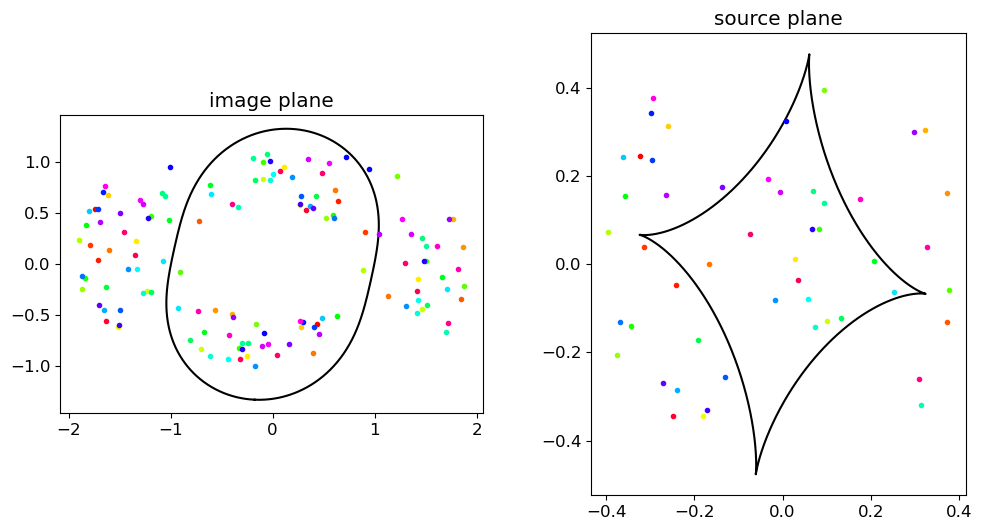

In [11]:
### get image positions, time delays, etc from pygravle

# specify the lens and source redshifts
zlens = 0.3
zsrc = 2.0

# note that the analysis needs comoving distances
Dl = cosmo70.comoving_distance(zlens)
Ds = cosmo70.comoving_distance(zsrc)


if root == 'CPLXS_':
    lim = 0.4
    N = 50
    truth = [0.0,0.0,1.0,1.0,0.,0.] #u,v,eta,b,ec,es
    gammac = 0.2
    gammas = 0.
elif root == 'EPLXS_':
    truth = [0.0,0.0,1.0,1.0,0.15,0.15] #u,v,eta,b,ec,es
    gammac = 0.22
    gammas = 0.
    lim = 0.4
    N = 50

plane = gl.lensplane('ellpow',truth, Dl=Dl, gammac=gammac, gammas=gammas)
model = gl.lensmodel([plane], Ds=Ds)
model.info()
model.tile()    

source_pos = np.random.uniform(size=(N,2), low=-lim,high=lim)

imgarr, muarr, tdarr = model.findimg(source_pos)

model.plot(src=source_pos)

np.save(folder+root+'_caus.npy', model.caus, allow_pickle=True)
np.save(folder+root+'_crit.npy', model.crit, allow_pickle=True)


In [12]:
### save image info into .dat file
source_pos_save = []
index = 1
flags = []
for nn in range(0,N):
    if len(imgarr[nn]) == 4:
        source_pos_save.append(source_pos[nn])
        outname = folder+root+str(index)+'.dat'
        #print(outname)
        writemock(imgarr[nn],muarr[nn],tdarr[nn],source_pos[nn], outname)
        index +=1
        flags.append(True)
    else:
        flags.append(False)
np.savetxt(folder+root+'source_pos.dat', source_pos_save)

wrote file: ./EPLXS_1.dat
wrote file: ./EPLXS_2.dat
wrote file: ./EPLXS_3.dat
wrote file: ./EPLXS_4.dat
wrote file: ./EPLXS_5.dat
wrote file: ./EPLXS_6.dat
wrote file: ./EPLXS_7.dat
wrote file: ./EPLXS_8.dat
wrote file: ./EPLXS_9.dat
wrote file: ./EPLXS_10.dat
wrote file: ./EPLXS_11.dat
wrote file: ./EPLXS_12.dat
wrote file: ./EPLXS_13.dat
wrote file: ./EPLXS_14.dat
wrote file: ./EPLXS_15.dat
wrote file: ./EPLXS_16.dat
wrote file: ./EPLXS_17.dat
wrote file: ./EPLXS_18.dat


In [13]:
### generate plots of mock data from pygravlens

savefig=True
size=8
index = 1
for nn in range(0,N):
    if flags[nn] == True:
        outname = root+str(index)

        fig, axes = plt.subplots(2,1, figsize=(4, 8), constrained_layout=True)#figsize=(16, 15)
        #axx = fig.add_subplot(111)

        lim = 2.0
        axes[0].plot(model.caus[0][:,0], model.caus[0][:,1], color='black')
        axes[0].plot(source_pos[nn][0], source_pos[nn][1], '*', color='turquoise', markersize=size)
        axes[0].set_xlabel('U')
        axes[0].set_ylabel('V')

        axes[1].plot(model.crit[0][:,0], model.crit[0][:,1], color='black')
        axes[1].plot(imgarr[nn][:,0], imgarr[nn][:,1], '*', color='turquoise', markersize=size)
        axes[1].set_xlabel('X')
        axes[1].set_ylabel('Y')
        for n in range(0,2):
            axes[n].set_xlim([-lim,lim])
            axes[n].set_ylim([-lim,lim])
            axes[n].set_aspect('equal', adjustable='box')
            axes[n].grid()

        if savefig == True:
            plt.savefig(folder+'skymap-'+outname+'.pdf', bbox_inches='tight')

        plt.close()
        print(outname)
        index += 1 

EPLXS_1
EPLXS_2
EPLXS_3
EPLXS_4
EPLXS_5
EPLXS_6
EPLXS_7
EPLXS_8
EPLXS_9
EPLXS_10
EPLXS_11
EPLXS_12
EPLXS_13
EPLXS_14
EPLXS_15
EPLXS_16
EPLXS_17
EPLXS_18
